In [1]:
import pandas as pd
import numpy as np
import mord as m
from mord import LogisticAT
from sklearn.preprocessing import StandardScaler
pd.options.display.max_columns = 999
ML_data = pd.read_csv('ML_data.csv')
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from matplotlib import pyplot as plt

In [2]:
MIC_ML_data = ML_data.dropna(subset = ['METHOD_MIC'])

In [3]:
MIC_strings = []

for i in MIC_ML_data['METHOD_MIC']:
    if i == '3.2':
        MIC_strings.append('>1.6')
    elif i == '6.4':
        MIC_strings.append('>1.6')
    elif i == '12.8':
        MIC_strings.append('>1.6')
    elif i == '>12.8':
        MIC_strings.append('>1.6')
    else:
        MIC_strings.append(i)
        
MIC_ML_data['MIC_values'] = MIC_strings

C:\Users\user\AppData\Local\Temp/ipykernel_30004/892947722.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MIC_ML_data['MIC_values'] = MIC_strings


In [4]:
MIC_df = MIC_ML_data[['MIC_values','MUT_RESISTANCE','MUTATION','Site1_Distance','d_volume','d_MW',	\
              'd_hydropathy', 'd_Pi', 'Depth','H','O','T','S','G','E',  \
              'B','I','Tempfactor','Hem_dist']]

# creates features numpy array
MIC_features = MIC_df[MIC_df.columns[2:]].to_numpy()

#creates resistance label column
MIC_label = MIC_df['MIC_values'].to_numpy()

In [5]:
#split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(MIC_features, MIC_label,
                                                    random_state=0)

In [6]:
# creates features and label dfs from unique mutations when the original train-test split 
# is inputted 
def remove_duplicate_mutations(X_dataset, y_dataset):

    #converts long X_train and y_train to pd df to join
    X_train_df = pd.DataFrame(X_dataset)
    X_train_df.rename(columns = {0:'MUTATION'}, inplace = True)
    y_train_df = pd.DataFrame(y_dataset)
    y_train_df.rename(columns = {0:'MIC_VALUES'}, inplace = True)

    CV_train = X_train_df.join(y_train_df,  how = 'inner')

    #converts MIC_values to an integer so that the mean can be calculated for each mutation
    #with multiple samples
    MIC_integers = []

    for i in CV_train['MIC_VALUES']:
        if i == '<=0.025':
            MIC_integers.append(1)
        elif i == '0.05':
            MIC_integers.append(2)
        elif i == '0.1':
            MIC_integers.append(3)
        elif i == '0.2':
            MIC_integers.append(4)
        elif i == '0.4':
            MIC_integers.append(5)
        elif i == '0.8':
            MIC_integers.append(6)
        elif i == '1.6':
            MIC_integers.append(7)
        elif i == '>1.6':
            MIC_integers.append(8)
        
    CV_train['MIC_integers'] = MIC_integers

    #calculates the mean MIC value using the integer scale for each mutation
    MIC_calc_df = CV_train[['MUTATION','MIC_integers']].groupby('MUTATION').mean()
    
    #rounds the mean MIC value to the nearest integer for conversion back to the 
    #original MIC classes
    MIC_rounded = []
    for i in MIC_calc_df['MIC_integers']:
        rnd = round(i)
        MIC_rounded.append(rnd)
    MIC_calc_df['MIC_rounded'] = MIC_rounded

    # joins new MIC classes to CV_train df to replace the variation in MIC values associated
    # with mutations with multiple DST_measurements 
    MIC_calc_df.drop(['MIC_integers'], axis =1, inplace = True)
    CV_train.set_index('MUTATION', inplace = True)
    CV_train = CV_train.join(MIC_calc_df)
    CV_train.reset_index(inplace = True)
    CV_train.drop(['MIC_VALUES','MIC_integers'], axis = 1, inplace = True)
    CV_train.rename(columns = {'index':'MUTATION','MIC_rounded':'MIC_VALUES'}, inplace = True)
    
    #removes duplicates and mutation column
    CV_train_unique = CV_train.drop_duplicates(subset='MUTATION', keep = 'first')
    CV_train_unique.drop(['MUTATION'], axis = 1, inplace = True)

    #seperates into unique features and label numpy arrays
    features_unique = CV_train_unique[CV_train_unique.columns[:-1]].to_numpy()
    label_unique = CV_train_unique['MIC_VALUES']

    X_no_duplicates = (features_unique)
    y_no_duplicates = (label_unique)
    
    return (X_no_duplicates, y_no_duplicates)

In [7]:
X_train_nodup, y_train_nodup = remove_duplicate_mutations(X_train, y_train)
X_test_nodup, y_test_nodup = remove_duplicate_mutations(X_test, y_test)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [8]:
#split data into training and test sets
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train_nodup, y_train_nodup,
                                                    random_state=0)

In [9]:
ordinal_IT = m.LogisticIT()
ordinal_AT = m.LogisticAT()

param_grid = {'alpha':[0.001,0.01,0.1,1,10,100,1000,10000]}

Produce confusion matrix for intermediate threshold ordinal regression model

In [10]:
#Grid search with kfold cross validation (best cv for logreg multiclass classifcation)

KFold = KFold(n_splits=5)
grid_kfold = GridSearchCV(ordinal_IT, param_grid, cv=KFold, n_jobs=-1)
grid_kfold.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold.best_score_)
print ('grid_kfold_shuffle: test set average accuracy: ', 
       accuracy_score(y_test_cv, grid_kfold.predict(X_test_cv)), '\n')

grid_kfold_shuffle: best estimator: 
 LogisticIT(alpha=1000)
grid_kfold_shuffle: best cross-validation score:  0.3062068965517242
grid_kfold_shuffle: test set average accuracy:  0.28 



In [11]:
ordinal_IT = m.LogisticIT(alpha = 1000)

In [12]:
#copy and fit classifier with best parameters from previous section
ordinal = ordinal_IT
ordinal.fit(X_train_nodup, y_train_nodup)                 
                 
predict = ordinal.predict(X_test_nodup)

#generate confusion matrix
from sklearn.metrics import confusion_matrix
ints = [1,2,3,4,5,6,7,8]
confusion = confusion_matrix(y_test_nodup, predict)

print ('\n confusion matrix: \n', confusion)


 confusion matrix: 
 [[1 6 0 0 0 0 0 1]
 [3 6 0 0 0 0 0 0]
 [1 4 0 0 0 0 0 7]
 [1 7 0 0 0 0 0 5]
 [1 1 0 0 0 0 0 6]
 [0 3 0 0 0 0 0 5]
 [0 0 0 0 0 0 0 4]
 [0 5 0 0 0 0 0 8]]


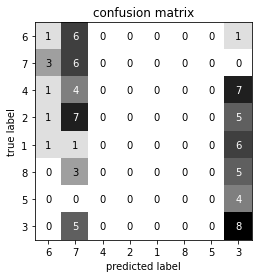

In [13]:
#generate heatmap of confusion matrix for visualisation
import mglearn

target_names = y_train_nodup.unique().tolist()
scores_image = mglearn.tools.heatmap(confusion, xlabel='predicted label',
                                     ylabel='true label', xticklabels=target_names,
                                     yticklabels=target_names, cmap=plt.cm.gray_r, fmt='%d')
plt.title('confusion matrix')
plt.gca().invert_yaxis()

In [14]:
#generate classification report
from sklearn.metrics import classification_report

print (classification_report(y_test_nodup, predict, zero_division=True))

              precision    recall  f1-score   support

           1       0.14      0.12      0.13         8
           2       0.19      0.67      0.29         9
           3       1.00      0.00      0.00        12
           4       1.00      0.00      0.00        13
           5       1.00      0.00      0.00         8
           6       1.00      0.00      0.00         8
           7       1.00      0.00      0.00         4
           8       0.22      0.62      0.33        13

    accuracy                           0.20        75
   macro avg       0.69      0.18      0.09        75
weighted avg       0.68      0.20      0.11        75



In [15]:
# will categorise multiclass data into 2 groups
def MIC_to_binary(data):
    RS_dict = {1:[4,5,6,7,8],
           0:[1,2,3]}
    binary_list = []
    for i in data:
        for k,v in RS_dict.items():
            for j in v:
                if i == j:
                    binary_list.append(k)

    binary_array = np.array(binary_list)
    return binary_array

In [16]:
#generate confusion matrix
confusion = confusion_matrix(MIC_to_binary(y_test_nodup), MIC_to_binary(predict))

#calculate precision, sensitivity, specificty, FPR, and errors
Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
very_major_error = (confusion[0][1]/y_test_nodup[y_test_nodup==0].count())*100
major_error = (confusion[1][0]/y_test_nodup[y_test_nodup==1].count())*100


print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
print ('very major error :', very_major_error)
print ('major error: ', major_error)
print ('\n confusion matrix: \n', confusion)

Precision:  0.7777777777777778
Sensitivity:  0.6086956521739131
Specificity:  0.7241379310344828
FPR : 0.27586206896551724
very major error : inf
major error:  225.0

 confusion matrix: 
 [[21  8]
 [18 28]]


C:\Users\user\AppData\Local\Temp/ipykernel_30004/4269136536.py:9: RuntimeWarning: divide by zero encountered in longlong_scalars
  very_major_error = (confusion[0][1]/y_test_nodup[y_test_nodup==0].count())*100


In [17]:
print (classification_report(MIC_to_binary(y_test_nodup), MIC_to_binary(predict)))

              precision    recall  f1-score   support

           0       0.54      0.72      0.62        29
           1       0.78      0.61      0.68        46

    accuracy                           0.65        75
   macro avg       0.66      0.67      0.65        75
weighted avg       0.69      0.65      0.66        75



Produce confusion matrix for all threshold ordinal regression model

In [18]:
#Grid search with kfold cross validation (best cv for logreg multiclass classifcation)

# KFold = KFold(n_splits=5) - code in previous section
grid_kfold = GridSearchCV(ordinal_AT, param_grid, cv=KFold, n_jobs=-1)
grid_kfold.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold.best_score_)
print ('grid_kfold_shuffle: test set average accuracy: ', 
       accuracy_score(y_test_cv, grid_kfold.predict(X_test_cv)), '\n')

grid_kfold_shuffle: best estimator: 
 LogisticAT(alpha=10000)
grid_kfold_shuffle: best cross-validation score:  -1.9114942528735632
grid_kfold_shuffle: test set average accuracy:  0.1 



In [19]:
ordinal_AT = m.LogisticAT(alpha = 10000)

In [20]:
#copy and fit classifier with best parameters from previous section
ordinal = ordinal_AT
ordinal.fit(X_train_nodup, y_train_nodup)                 
                 
predict = ordinal.predict(X_test_nodup)

#generate confusion matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test_nodup, predict)

print ('\n confusion matrix: \n', confusion)


 confusion matrix: 
 [[0 3 1 3 1 0 0 0]
 [0 6 1 1 1 0 0 0]
 [0 4 0 1 4 3 0 0]
 [0 4 1 2 2 4 0 0]
 [0 1 0 0 5 2 0 0]
 [0 1 0 0 4 3 0 0]
 [0 0 0 0 3 1 0 0]
 [0 2 0 2 2 7 0 0]]


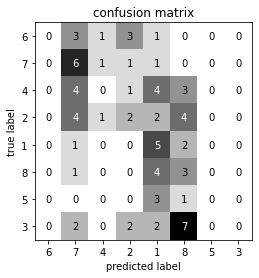

In [21]:
#generate heatmap of confusion matrix for visualisation
import mglearn

target_names = y_train_nodup.unique().tolist()
scores_image = mglearn.tools.heatmap(confusion, xlabel='predicted label',
                                     ylabel='true label', xticklabels=target_names,
                                     yticklabels=target_names, cmap=plt.cm.gray_r, fmt='%d')
plt.title('confusion matrix')
plt.gca().invert_yaxis()

In [22]:
#generate classification report
from sklearn.metrics import classification_report

print (classification_report(y_test_nodup, predict, zero_division=True))

              precision    recall  f1-score   support

           1       1.00      0.00      0.00         8
           2       0.29      0.67      0.40         9
           3       0.00      0.00      0.00        12
           4       0.22      0.15      0.18        13
           5       0.23      0.62      0.33         8
           6       0.15      0.38      0.21         8
           7       1.00      0.00      0.00         4
           8       1.00      0.00      0.00        13

    accuracy                           0.21        75
   macro avg       0.49      0.23      0.14        75
weighted avg       0.45      0.21      0.14        75



In [23]:
# uses MIC_to_binary function defined in previous section

In [24]:
#generate confusion matrix
confusion = confusion_matrix(MIC_to_binary(y_test_nodup), MIC_to_binary(predict))

#calculate precision, sensitivity, specificty, FPR, and errors
Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
very_major_error = (confusion[0][1]/y_test_nodup[y_test_nodup==0].count())*100
major_error = (confusion[1][0]/y_test_nodup[y_test_nodup==1].count())*100


print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
print ('very major error :', very_major_error)
print ('major error: ', major_error)
print ('\n confusion matrix: \n', confusion)

Precision:  0.7254901960784313
Sensitivity:  0.8043478260869565
Specificity:  0.5172413793103449
FPR : 0.48275862068965514
very major error : inf
major error:  112.5

 confusion matrix: 
 [[15 14]
 [ 9 37]]


C:\Users\user\AppData\Local\Temp/ipykernel_30004/4269136536.py:9: RuntimeWarning: divide by zero encountered in longlong_scalars
  very_major_error = (confusion[0][1]/y_test_nodup[y_test_nodup==0].count())*100


In [25]:
print (classification_report(MIC_to_binary(y_test_nodup), MIC_to_binary(predict)))

              precision    recall  f1-score   support

           0       0.62      0.52      0.57        29
           1       0.73      0.80      0.76        46

    accuracy                           0.69        75
   macro avg       0.68      0.66      0.66        75
weighted avg       0.69      0.69      0.69        75



In [26]:
# all threshold model gives a better accuracy score - but still worse than RForest binary